C:\Users\loren\AppData\Local\Temp\ipykernel_23380\2526294484.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '175.79614325068871' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[(train_data['HeartDisease'] == 1) & (train_data['Cholesterol'] == 0), 'Cholesterol'] = mean_cholesterol_heart_disease_1


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Validation Accuracy: 89.92%
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Confusion Matrix:


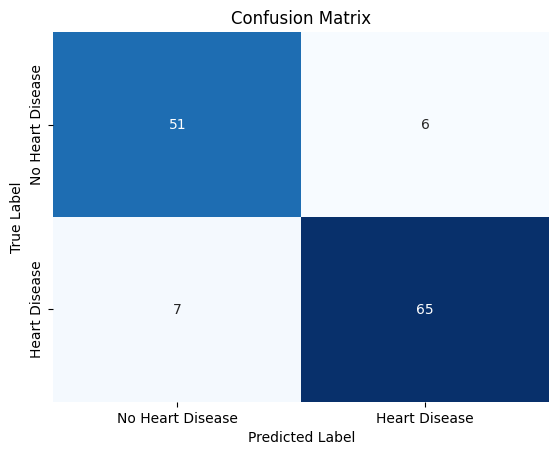

In [5]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load the training data
train_data = pd.read_csv('train_heart.csv')

# Calculate the mean of 'Cholesterol' for people with 'HeartDisease' = 1
mean_cholesterol_heart_disease_1 = train_data[train_data['HeartDisease'] == 1]['Cholesterol'].mean()
# Calculate the mean of 'Cholesterol' for people with 'HeartDisease' = 0
mean_cholesterol_heart_disease_0 = train_data[train_data['HeartDisease'] == 0]['Cholesterol'].mean()

# Replace zeros with the mean for 'Cholesterol' where 'HeartDisease' is 1
train_data.loc[(train_data['HeartDisease'] == 1) & (train_data['Cholesterol'] == 0), 'Cholesterol'] = mean_cholesterol_heart_disease_1
# Replace zeros with the mean for 'Cholesterol' where 'HeartDisease' is 0
train_data.loc[(train_data['HeartDisease'] == 0) & (train_data['Cholesterol'] == 0), 'Cholesterol'] = mean_cholesterol_heart_disease_0

# Encode categorical features using OneHotEncoder
categorical_features = ['Sex', 'Age', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_features = ['Cholesterol', 'MaxHR', 'Oldpeak']

# Modify the OneHotEncoder to handle unknown categories
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Separate features and target variable
X = train_data.drop('HeartDisease', axis=1)
y = train_data['HeartDisease']

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with the preprocessor, SimpleImputer and the XGBoost model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', XGBClassifier())])

# Define a grid of hyperparameters to search over
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.3]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions on the validation set
y_pred = best_model.predict(X_val)

accuracy = accuracy_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print('Best Parameters:', grid_search.best_params_)
print('Confusion Matrix:')

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Heart Disease', 'Heart Disease'],
            yticklabels=['No Heart Disease', 'Heart Disease'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
